# Refined Stratified Sampling Example 3

- Author: Mohit S. Chauhan 
- Date: June 30, 2020

In this example, Stratified sampling is used to generate samples from Uniform distribution and sample expnsion is done adaptively using Refined Stratified Sampling.

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the STS, RSS and Krig class from UQpy.


In [1]:
from UQpy.sampling import TrueStratifiedSampling, RefinedStratifiedSampling
from UQpy.surrogates import Kriging
from UQpy.RunModel import RunModel
from UQpy.distributions import Uniform
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as patches
import numpy as np
from UQpy.sampling.stratified_sampling.strata import RectangularStrata
from UQpy.optimization.MinimizeOptimizer import MinimizeOptimizer

/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
The selected optimizer method does not support bounds and thus will be ignored.
The selected optimizer method does not support bounds and thus

Create a distribution object.

In [2]:
marginals = [Uniform(loc=0., scale=1.), Uniform(loc=0., scale=1.)]

Create a strata object.

In [3]:
strata = RectangularStrata(strata_number=[4, 4])

Run stratified sampling.

In [4]:
x = TrueStratifiedSampling(distributions=marginals, strata_object=strata, nsamples_per_stratum=1, random_state=1)
initial_samples=x.samples.copy()

This plot shows the samples and stratas generated by the STS class.

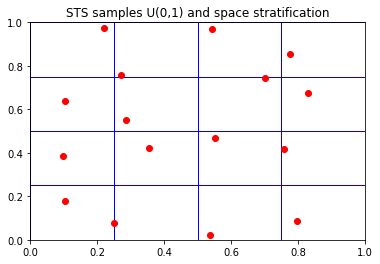

In [5]:
fig1 = x.strata_object.plot_2d()
plt.title("STS samples U(0,1) and space stratification")
plt.plot(x.samples[:16, 0], x.samples[:16, 1], 'ro')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

RunModel class is used to estimate the function value at sample points generated using STS class.

In [6]:
rmodel = RunModel(model_script='python_model_function.py', vec=False)

This figure shows the actual function defined in python model script.

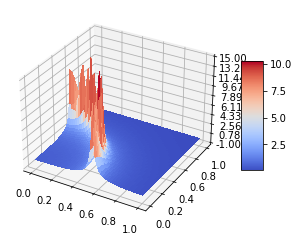

In [7]:
rmodel1 = RunModel(model_script='python_model_function.py', vec=False)
rmodel1.run(samples=x.samples)
num = 50
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y_act = np.zeros([num, num])
r1model = RunModel(model_script='python_model_function.py')
for i in range(num):
    for j in range(num):
        r1model.run(samples=np.array([[x1v[i, j], x2v[i, j]]]), append_samples=False)
        y_act[i, j] = r1model.qoi_list[0]
        
fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
# Plot for estimated values
surf = ax1.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax1.set_zlim(-1, 15)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Krig class generated a surrogate model using STS samples and function value at those points.

In [8]:
from UQpy.surrogates.kriging.regression_models import Linear
from UQpy.surrogates.kriging.correlation_models import Exponential
K = Kriging(regression_model=Linear(), correlation_model=Exponential(), optimizer=MinimizeOptimizer(method="L-BFGS-B"),
            optimizations_number=20, correlation_model_parameters=[1, 1])
K.fit(samples=x.samples, values=rmodel1.qoi_list)
print(K.correlation_model_parameters)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40249D+01    |proj g|=  2.62565D+00

At iterate    1    f=  2.16861D+01    |proj g|=  2.21272D-01

At iterate    2    f=  2.03748D+01    |proj g|=  1.77093D+00

At iterate    3    f=  2.03631D+01    |proj g|=  1.06030D-01

At iterate    4    f=  2.03593D+01    |proj g|=  9.98875D-02

At iterate    5    f=  2.03558D+01    |proj g|=  3.60282D-01

At iterate    6    f=  2.03525D+01    |proj g|=  4.88691D-01

At iterate    7    f=  2.03461D+01    |proj g|=  2.21094D-01

At iterate    8    f=  2.03454D+01    |proj g|=  6.98602D-02

At iterate    9    f=  2.03454D+01    |proj g|=  7.59689D-03

At iterate   10    f=  2.03454D+01    |proj g|=  1.01122D-04
True
At iterate   11    f=  2.03454D+01    |proj g|=  4.95015D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of functio

/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/optimization/MinimizeOptimizer.py:24: OptimizeWarning: Unknown solver options: catol
  return minimize(function, initial_guess, args=args,

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.


This figure shows the surrogate model generated using Krig class from initial samples.

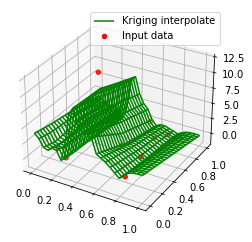

In [9]:
num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K.predict(np.array([x1v[i, j], x2v[i, j]]))

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
# Plot for estimated values
kr = ax2.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax2.scatter3D(x.samples[:, 0], x.samples[:, 1], rmodel1.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()

A RSS class object is initiated by using the STS, RunModel and Krig object.

In [10]:
from UQpy.sampling import GradientEnhancedRefinement
refinement = GradientEnhancedRefinement(strata=strata, runmodel_object=rmodel, surrogate=K)
z = RefinedStratifiedSampling(stratified_sampling=x, refinement_algorithm=refinement, random_state=2)

After initiating the RSS class object, new samples are generated using the RSS.sample method.

In [11]:
z.run(nsamples=50)

TrueRUNNING THE L-BFGS-B CODE

           * * *


[6563.02832216 1473.61024134]
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03454D+01    |proj g|=  4.71544D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.715D-07   2.035D+01
  F =   20.345406392955059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
TrueRUNNING THE L-BFGS-B CODE


[4.96065571e+05 2.51536264e+01]
           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0  


At iterate    6    f=  2.28328D+01    |proj g|=  2.71431D-02

At iterate    7    f=  2.28215D+01    |proj g|=  1.80633D-02

At iterate    8    f=  2.28213D+01    |proj g|=  1.31132D-03

True
[ 3603.83022545 40020.2604996 ]
At iterate    9    f=  2.28213D+01    |proj g|=  8.87337D-05

At iterate   10    f=  2.28213D+01    |proj g|=  1.41576D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     25     13     2     0   1.416D-07   2.282D+01
  F =   22.821298086404251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
True
[14.1786681   1.06090037]
RUNNING THE L-BFGS-B CODE

           * * *




 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  2.43242D+01    |proj g|=  1.52019D-02

At iterate    7    f=  2.36716D+01    |proj g|=  3.12051D-01
  ys=-2.447E+00  -gs= 1.318E-01 BFGS update SKIPPED

At iterate    8    f=  2.35969D+01    |proj g|=  2.26243D-01

At iterate    9    f=  2.33173D+01    |proj g|=  9.01005D-01

At iterate   10    f=  2.33000D+01    |proj g|=  1.33771D-01

At iterate   11    f=  2.32970D+01    |proj g|=  1.27154D-01

At iterate   12    f=  2.32965D+01    |proj g|=  3.91951D-02

At iterate   13    f=  2.32965D+01    |proj g|=  2.70844D-03

At iterate   14    f=  2.32965D+01    |proj g|=  3.89924D-05
True

[3.80043126e+03 1.50299580e+00]
At iterate   15    f=  2.32965D+01    |proj g|=  3.02231D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the fi

TrueRUNNING THE L-BFGS-B CODE

           * * *


[1.00827800e+00 2.96933894e+05]
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58852D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00   2.589D+01
  F =   25.885217921823092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at t


At iterate   11    f=  2.80771D+01    |proj g|=  1.35748D-03

At iterate   12    f=  2.80771D+01    |proj g|=  1.22166D-05
True

[732.23779265  68.20765661]
TrueAt iterate   13    f=  2.80771D+01    |proj g|=  5.06006D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     22     14     1     0   5.060D-07   2.808D+01
  F =   28.077069846054400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88363D+

True
At iterate   13    f=  3.00607D+01    |proj g|=  1.34723D-04

[1.00112876 1.00787616]

At iterate   14    f=  3.00607D+01    |proj g|=  2.14440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     16     15     0     0   2.144D-06   3.006D+01
  F =   30.060660459455118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46445D+01    |proj g|=  2.49661D+00

At iterate    1    f=  3.06134D+01    |p

At iterate    8    f=  3.13948D+01    |proj g|=  3.67929D-02

At iterate    9    f=  3.13800D+01    |proj g|=  3.59164D-02

At iterate   10    f=  3.13723D+01    |proj g|=  9.92046D-03

At iterate   11    f=  3.13722D+01    |proj g|=  8.42159D-03

At iterate   12    f=  3.13720D+01    |proj g|=  8.26115D-04

At iterate   13    f=  3.13720D+01    |proj g|=  7.30803D-05
True

[6.04424414e+05 4.43927149e+00]
At iterate   14    f=  3.13720D+01    |proj g|=  2.70730D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     15     14     0     0   2.707D-06   3.137D+01
  F =   31.372000978424772     

CONVERGENCE: N


At iterate   19    f=  3.27135D+01    |proj g|=  4.79267D-02

At iterate   20    f=  3.27057D+01    |proj g|=  2.58089D-02

At iterate   21    f=  3.27048D+01    |proj g|=  2.08551D-02

At iterate   22    f=  3.27039D+01    |proj g|=  4.01011D-03

At iterate   23    f=  3.27039D+01    |proj g|=  6.82438D-04

At iterate   24    f=  3.27039D+01    |proj g|=  5.08521D-05

At iterate   25    f=  3.27039D+01    |proj g|=  3.54883D-05
True

[3.04312572e+06 2.00157097e+00]
At iterate   26    f=  3.27039D+01    |proj g|=  1.03739D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     46     27     0     0   1.037D


At iterate   12    f=  3.39636D+01    |proj g|=  4.13572D-03

At iterate   13    f=  3.39636D+01    |proj g|=  3.40936D-03

At iterate   14    f=  3.39636D+01    |proj g|=  8.87754D-05
True

[1703606.48418064    5408.65559289]
At iterate   15    f=  3.39636D+01    |proj g|=  2.34477D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     23     17     0     0   2.345D-06   3.396D+01
  F =   33.963592453982642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
TrueRUNNING THE L-BFGS-B CODE

           * * *


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         

At iterate   23    f=  3.47393D+01    |proj g|=  6.52665D-02

At iterate   24    f=  3.47392D+01    |proj g|=  6.85541D-03

At iterate   25    f=  3.47392D+01    |proj g|=  1.75209D-04
True

[379.07042853   1.71538706]
At iterate   26    f=  3.47392D+01    |proj g|=  9.29348D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     38     27     2     0   9.293D-07   3.474D+01
  F =   34.739240524988077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables ar

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69409D+01    |proj g|=  1.65770D-02

At iterate    1    f=  3.69406D+01    |proj g|=  1.78571D-02
  ys=-2.122E-05  -gs= 2.748E-04 BFGS update SKIPPED

At iterate    2    f=  3.68382D+01    |proj g|=  1.19978D-01
  ys=-9.005E-02  -gs= 1.575E-02 BFGS update SKIPPED

At iterate    3    f=  3.68366D+01    |proj g|=  9.23805D-03

At iterate    4    f=  3.68366D+01    |proj g|=  2.69780D-03

At iterate    5    f=  3.68366D+01    |proj g|=  2.14233D-04
True

[4.91396750e+05 2.25018582e+00]
At iterate    6    f=  3.68366D+01    |proj g|=  2.54341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Ca

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82928D+01    |proj g|=  5.33031D-02

At iterate    1    f=  3.82897D+01    |proj g|=  6.38737D-02
  ys=-5.635E-04  -gs= 2.841E-03 BFGS update SKIPPED

At iterate    2    f=  3.80516D+01    |proj g|=  1.37511D-01
  ys=-2.595E-01  -gs= 5.202E-02 BFGS update SKIPPED

At iterate    3    f=  3.80450D+01    |proj g|=  8.47699D-02

At iterate    4    f=  3.80448D+01    |proj g|=  3.66255D-02

At iterate    5    f=  3.80448D+01    |proj g|=  2.71443D-03

At iterate    6    f=  3.80448D+01    |proj g|=  2.71491D-03

At iterate    7    f=  3.80448D+01    |proj g|=  3.24085D-03

At iterate    8    f=  3.80448D+01    |proj g|=  8.96934D-03

At iterate    9    f=  3.80448D+01    |proj g|=  1.77741D-02

At iterate   10    f=  3.80447D+01    |proj g|=  3.25288D-02

At iterate   11    f=  3.80447D+01    |proj g|


At iterate   10    f=  3.79771D+01    |proj g|=  1.04394D-01

At iterate   11    f=  3.79734D+01    |proj g|=  1.04228D-01

At iterate   12    f=  3.79699D+01    |proj g|=  9.84933D-02

At iterate   13    f=  3.79691D+01    |proj g|=  3.21181D-02

At iterate   14    f=  3.79691D+01    |proj g|=  2.41954D-03
True

At iterate   15    f=  3.79691D+01    |proj g|=  2.24088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     18     16     0     0   2.241D-05   3.797D+01
  F =   37.969094962481883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
[253825.2454218   1827.5039888]
TrueRUNNING TH


At iterate   21    f=  3.79693D+01    |proj g|=  2.12825D-03

At iterate   22    f=  3.79691D+01    |proj g|=  2.41591D-03

At iterate   23    f=  3.79691D+01    |proj g|=  6.53791D-05
True

[2.53565604e+06 9.27026680e+00]
At iterate   24    f=  3.79691D+01    |proj g|=  4.16267D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     49     27     2     0   4.163D-07   3.797D+01
  F =   37.969094962476817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
TrueRUNNING THE L-BFGS-B CODE

           * * *


[1.11471888e+00 3.00265102e+06]
Machine precision = 2.220D-16
 N =            2     M = 

At iterate   16    f=  4.22485D+01    |proj g|=  7.84682D-01

At iterate   17    f=  4.22303D+01    |proj g|=  2.21116D+00

At iterate   18    f=  4.20880D+01    |proj g|=  1.53781D+01

At iterate   19    f=  4.20880D+01    |proj g|=  1.56071D+01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   20    f=  4.14352D+01    |proj g|=  2.67053D+01

At iterate   21    f=  4.09512D+01    |proj g|=  1.37116D-01

At iterate   22    f=  4.09481D+01    |proj g|=  1.37419D-01

At iterate   23    f=  4.09270D+01    |proj g|=  1.13919D-01

At iterate   24    f=  4.09257D+01    |proj g|=  3.54348D-01

At iterate   25    f=  4.09248D+01    |proj g|=  4.41062D-02

At iterate   26    f=  4.09248D+01    |proj g|=  3.75710D-03

At iterate   27    f=  4.09248D+01    |proj g|=  5.43511D-05
True

[ 1.61259195 69.60186021]
At iterate   28    f=  4.09248D+01    |proj g|=  2.38377D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evalu


At iterate    6    f=  4.22342D+01    |proj g|=  3.39842D-01

At iterate    7    f=  4.22325D+01    |proj g|=  4.19152D-01

At iterate    8    f=  4.22310D+01    |proj g|=  3.07089D-01

At iterate    9    f=  4.22303D+01    |proj g|=  1.13558D-01

At iterate   10    f=  4.22302D+01    |proj g|=  1.22893D-02

At iterate   11    f=  4.22302D+01    |proj g|=  2.62896D-04
True

[  1.00462618 276.01045821]
At iterate   12    f=  4.22302D+01    |proj g|=  8.37109D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     16     12     0     0   8.371D-06   4.223D+01
  F =   42.230213473302570     

CONVERGENCE: NORM


At iterate   11    f=  4.35234D+01    |proj g|=  4.33421D-02

At iterate   12    f=  4.35218D+01    |proj g|=  2.00313D-02

At iterate   13    f=  4.35086D+01    |proj g|=  1.79076D-02

At iterate   14    f=  4.34974D+01    |proj g|=  3.15994D-02

At iterate   15    f=  4.34950D+01    |proj g|=  8.10859D-03

At iterate   16    f=  4.34946D+01    |proj g|=  1.99335D-03

At iterate   17    f=  4.34946D+01    |proj g|=  4.40020D-04

At iterate   18    f=  4.34946D+01    |proj g|=  4.88742D-05
True

[1.13317557 1.56466541]
At iterate   19    f=  4.34946D+01    |proj g|=  5.75485D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg   


At iterate   11    f=  4.49018D+01    |proj g|=  4.51224D-03

At iterate   12    f=  4.49008D+01    |proj g|=  7.13039D-03

At iterate   13    f=  4.48102D+01    |proj g|=  3.90523D-02
  ys=-6.630E-01  -gs= 1.771E-02 BFGS update SKIPPED
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   14    f=  4.47911D+01    |proj g|=  2.70624D-02

At iterate   15    f=  4.45802D+01    |proj g|=  4.14230D-02

At iterate   16    f=  4.45786D+01    |proj g|=  8.72267D-03

At iterate   17    f=  4.45590D+01    |proj g|=  2.90127D-03

At iterate   18    f=  4.45555D+01    |proj g|=  5.34237D-03

At iterate   19    f=  4.45555D+01    |proj g|=  9.00631D-04

At iterate   20    f=  4.45555D+01    |proj g|=  3.01173D-05
True

At iterate   21    f=  4.45555D+01    |proj g|=  4.95064D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS up

TrueRUNNING THE L-BFGS-B CODE

           * * *


[5695.30182731    6.64857601]
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60652D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00   4.607D+01
  F =   46.065165539624481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
TrueRUNNING THE L-BFGS-B CODE

           * * *


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly a


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80914D+01    |proj g|=  1.85292D+00

At iterate    1    f=  4.65236D+01    |proj g|=  2.85245D-01

At iterate    2    f=  4.63970D+01    |proj g|=  2.03638D-01

At iterate    3    f=  4.58716D+01    |proj g|=  3.48907D-02

At iterate    4    f=  4.58665D+01    |proj g|=  3.13156D-02

At iterate    5    f=  4.58639D+01    |proj g|=  2.38016D-02

At iterate    6    f=  4.58605D+01    |proj g|=  2.61209D-03

At iterate    7    f=  4.58605D+01    |proj g|=  2.66201D-04
True

[1.10313891e+00 5.88934212e+06]
At iterate    8    f=  4.58605D+01    |proj g|=  3.57856D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at 


At iterate   12    f=  4.82820D+01    |proj g|=  1.64029D-01
  ys=-1.440E-01  -gs= 3.155E-02 BFGS update SKIPPED
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   13    f=  4.82262D+01    |proj g|=  1.68406D-01

At iterate   14    f=  4.74166D+01    |proj g|=  2.69286D-01

At iterate   15    f=  4.72359D+01    |proj g|=  2.20072D-01

At iterate   16    f=  4.71627D+01    |proj g|=  1.48905D-01

At iterate   17    f=  4.71446D+01    |proj g|=  6.56373D-02

At iterate   18    f=  4.71382D+01    |proj g|=  1.61638D-02

At iterate   19    f=  4.71379D+01    |proj g|=  4.76413D-03

At iterate   20    f=  4.71379D+01    |proj g|=  2.19834D-04

At iterate   21    f=  4.71379D+01    |proj g|=  4.78569D-05
True

[ 37.30086154 764.569911  ]
At iterate   22    f=  4.71379D+01    |proj g|=  2.94511D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search


At iterate    9    f=  4.90315D+01    |proj g|=  2.08416D+00

At iterate   10    f=  4.85101D+01    |proj g|=  2.93557D-01

At iterate   11    f=  4.83623D+01    |proj g|=  2.04429D-01

At iterate   12    f=  4.83484D+01    |proj g|=  1.21724D-01

At iterate   13    f=  4.83387D+01    |proj g|=  3.05048D-02

At iterate   14    f=  4.83381D+01    |proj g|=  3.87052D-03

At iterate   15    f=  4.83381D+01    |proj g|=  1.52020D-04
True

[1.00669433 1.25100262]
At iterate   16    f=  4.83381D+01    |proj g|=  1.19170D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     26     16     0     0   1.192D-06   4.

At iterate    8    f=  5.15672D+01    |proj g|=  9.20248D-03

At iterate    9    f=  5.15668D+01    |proj g|=  1.25286D-03

At iterate   10    f=  5.15667D+01    |proj g|=  8.30007D-04

At iterate   11    f=  5.15667D+01    |proj g|=  1.30607D-04
True

[590.59146371   1.00268312]
At iterate   12    f=  5.15667D+01    |proj g|=  1.25080D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     33     12     1     0   1.251D-06   5.157D+01
  F =   51.566743801484769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

True

[7127930.53607247  677769.41593516]
At iterate    2    f=  5.49142D+01    |proj g|=  4.00685D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      8      2     1     0   4.007D-06   5.491D+01
  F =   54.914239223307113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
TrueRUNNING THE L-BFGS-B CODE


[  5.04091007 941.30646795]
           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49268D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf 


At iterate    2    f=  5.62907D+01    |proj g|=  5.57126D-04

At iterate    3    f=  5.62903D+01    |proj g|=  2.11345D-04

At iterate    4    f=  5.62902D+01    |proj g|=  1.07040D-04

At iterate    5    f=  5.62901D+01    |proj g|=  4.73237D-05

At iterate    6    f=  5.62901D+01    |proj g|=  2.05867D-05
True

[5.00837076e+03 4.55766610e+00]
At iterate    7    f=  5.62901D+01    |proj g|=  7.78700D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     13      7     1     0   7.787D-06   5.629D+01
  F =   56.290081044713780     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-

True
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62901D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00   5.629D+01
  F =   56.290146572736901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=


At iterate    3    f=  5.48661D+01    |proj g|=  6.29818D-02

At iterate    4    f=  5.48479D+01    |proj g|=  2.19004D-02

At iterate    5    f=  5.48457D+01    |proj g|=  1.86811D-02

At iterate    6    f=  5.48451D+01    |proj g|=  3.62222D-04

At iterate    7    f=  5.48451D+01    |proj g|=  1.62693D-05
True

At iterate    8    f=  5.48451D+01    |proj g|=  6.99885D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8      9      8     0     0   6.999D-07   5.485D+01
  F =   54.845073182718963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

M


At iterate    6    f=  5.61299D+01    |proj g|=  2.69177D-04

At iterate    7    f=  5.61299D+01    |proj g|=  2.57099D-05
True

[1.30014895 1.00274401]
At iterate    8    f=  5.61299D+01    |proj g|=  2.41953D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8      9      8     0     0   2.420D-08   5.613D+01
  F =   56.129906344141475     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42371D+01    |p


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.


True

[1200.5020884     3.05507187]
At iterate   27    f=  5.76754D+01    |proj g|=  1.48156D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     41     29     1     0   1.482D-07   5.768D+01
  F =   57.675381567567200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05041D+01    |proj g|=  2.15967D-03

At iterate    1    f=  6.05041D+01    |proj g|=  2.16603D-03
  ys=-1.373E-08  -gs= 4.664E-06 BFG


At iterate    3    f=  6.12454D+01    |proj g|=  6.19424D-02

At iterate    4    f=  6.12453D+01    |proj g|=  5.26567D-02

At iterate    5    f=  6.12452D+01    |proj g|=  3.83164D-03

At iterate    6    f=  6.12452D+01    |proj g|=  3.83136D-03

At iterate    7    f=  6.12452D+01    |proj g|=  6.60944D-03

At iterate    8    f=  6.12452D+01    |proj g|=  1.50848D-02

At iterate    9    f=  6.12452D+01    |proj g|=  3.04553D-02

At iterate   10    f=  6.12451D+01    |proj g|=  5.48898D-02

At iterate   11    f=  6.12450D+01    |proj g|=  9.63894D-02

At iterate   12    f=  6.12445D+01    |proj g|=  1.66900D-01

At iterate   13    f=  6.12432D+01    |proj g|=  2.92030D-01

At iterate   14    f=  6.12396D+01    |proj g|=  5.27126D-01

At iterate   15    f=  6.12290D+01    |proj g|=  1.02081D+00

At iterate   16    f=  6.11959D+01    |proj g|=  2.31154D+00

At iterate   17    f=  6.11023D+01    |proj g|=  7.50545D+00

At iterate   18    f=  6.10091D+01    |proj g|=  7.63717D+00

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33687D+01    |proj g|=  6.19647D-05
True

[8451848.35078445   52875.11908241]
At iterate    1    f=  6.33687D+01    |proj g|=  6.19712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      2      1     0     0   6.197D-05   6.337D+01
  F =   63.368716738508368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
TrueRUNNING THE L-BFGS-B CODE

           * * *


[6.30689805e+04 1.03177527e+00]
Machine p


At iterate    7    f=  6.47517D+01    |proj g|=  7.01637D-04

At iterate    8    f=  6.47514D+01    |proj g|=  2.96813D-04

At iterate    9    f=  6.47513D+01    |proj g|=  1.08388D-04

At iterate   10    f=  6.47513D+01    |proj g|=  2.88910D-05

At iterate   11    f=  6.47513D+01    |proj g|=  1.20277D-05

At iterate   12    f=  6.47513D+01    |proj g|=  1.19659D-05

At iterate   13    f=  6.47513D+01    |proj g|=  2.34683D-05

At iterate   14    f=  6.47513D+01    |proj g|=  4.74867D-05

At iterate   15    f=  6.47513D+01    |proj g|=  8.63068D-05

At iterate   16    f=  6.47512D+01    |proj g|=  1.47802D-04

At iterate   17    f=  6.47511D+01    |proj g|=  2.62043D-04

At iterate   18    f=  6.34056D+01    |proj g|=  6.19887D-02
  ys=-1.044E+01  -gs= 1.297E-03 BFGS update SKIPPED

At iterate   19    f=  6.26261D+01    |proj g|=  1.86189D-01

At iterate   20    f=  6.23741D+01    |proj g|=  1.95235D-01

At iterate   21    f=  6.19514D+01    |proj g|=  1.33554D-01

At iterate   22  


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    2    f=  6.32030D+01    |proj g|=  5.69958D-02

At iterate    3    f=  6.31961D+01    |proj g|=  4.58546D-02

At iterate    4    f=  6.31919D+01    |proj g|=  1.75070D-02

At iterate    5    f=  6.31910D+01    |proj g|=  1.15773D-02

At iterate    6    f=  6.31902D+01    |proj g|=  6.38149D-04

At iterate    7    f=  6.31902D+01    |proj g|=  2.13970D-05
True

[1.07354354 7.86650541]
At iterate    8    f=  6.31902D+01    |proj g|=  3.86876D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      8     0     0   3.869D-07   6.319D+01
  F =   63.190220642699749     

CONVERGENCE: NORM_OF_

TrueRUNNING THE L-BFGS-B CODE

           * * *


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61206D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00   6.612D+01
  F =   66.120581351746083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
[4.13804194e+03 1.00913660e+00]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at t


At iterate    6    f=  6.51066D+01    |proj g|=  1.68100D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    7    f=  6.51057D+01    |proj g|=  1.59062D-01

At iterate    8    f=  6.44594D+01    |proj g|=  8.38259D-02

At iterate    9    f=  6.44401D+01    |proj g|=  9.05306D-03

At iterate   10    f=  6.44399D+01    |proj g|=  2.76777D-03

At iterate   11    f=  6.44399D+01    |proj g|=  2.65303D-03

At iterate   12    f=  6.44399D+01    |proj g|=  8.27760D-04
True

[1.16308356 1.00165822]
At iterate   13    f=  6.44399D+01    |proj g|=  4.70900D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact   

This figure shows the final samples generated using RSS class, where red dots shows the initial samples.

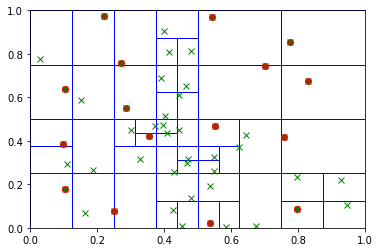

In [12]:
fig3 = strata.plot_2d()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(initial_samples[:, 0], initial_samples[:, 1], 'ro')
plt.plot(z.samplesU01[:, 0], z.samplesU01[:, 1], 'gx')
plt.show()

Krig class is used to generate a surrogate model using final samples from RSS class.

In [13]:
K2 = Kriging(regression_model=Linear(), correlation_model=Exponential(), optimizer=MinimizeOptimizer(method="L-BFGS-B"),
             correlation_model_parameters=K.correlation_model_parameters.tolist())
K2.fit(samples=z.samples, values=rmodel.qoi_list)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55843D+01    |proj g|=  1.81146D-02

At iterate    1    f=  6.55839D+01    |proj g|=  1.44681D-02

At iterate    2    f=  6.55821D+01    |proj g|=  2.23856D-03

At iterate    3    f=  6.55821D+01    |proj g|=  8.50959D-04
True

At iterate    4    f=  6.55821D+01    |proj g|=  3.04747D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      4     0     0   3.047D-06   6.558D+01
  F =   65.582050934264345     

CO

/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/optimization/MinimizeOptimizer.py:24: OptimizeWarning: Unknown solver options: catol
  return minimize(function, initial_guess, args=args,


This figure shows the final surrogate model, generated using 200 samples.

<Figure size 432x288 with 0 Axes>

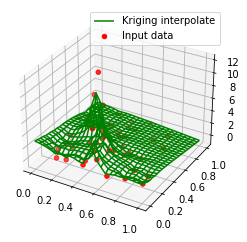

In [14]:
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K2.predict(np.array([x1v[i, j], x2v[i, j]]))

plt.clf()
fig4 = plt.figure()
a4 = fig4.gca(projection='3d')
# Plot for estimated values
kr = a4.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = a4.scatter3D(z.samples[:, 0], z.samples[:, 1], rmodel.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()